<div style="position: relative;">
<img src="https://user-images.githubusercontent.com/7065401/98728503-5ab82f80-2378-11eb-9c79-adeb308fc647.png"></img>

<h1 style="color: white; position: absolute; top:27%; left:10%;">
     Secure RESTful APIs using Python
</h1>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:56%; left:10%;">
    David Mertz, Ph.D.
</h3>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:63%; left:10%;">
    Data Scientist
</h3>
</div>

# Stateless Web Services

The original design of the World Wide Web (WWW) focused on HTTP servers that simply processed the URL which they received as a request, and returned a result that was based on nothing other than the contents of that query.  In the early days, that URL was exclusively a *path* and the result was usually an HTML page. 

Over time the use of a *query* component became more widespread to *parameterize* the query being performed. Extra compontents of a path are also sometimes used as parameters. Also around the same time, a mechanism to *personalize* queries developed, i.e. *cookies* to store information about the **state** of an interaction with a web service.  In the decades since then, additional mechanisms for statefulness have developed, and the URLs we interact with typically maintain hundred or thousands of distinct fields of information about each user and each transaction.

## Becoming RESTful

In 2000, Roy Fielding introduced the term *representational state transfer* to characterize HTTP architectures that do not rely on state, but simply return results based on the content of queries.  However, in contrast to the very earliest WWW sites, the results in RESTful designs are more typically some sort of data, usually encapsulated in formats other than HTML.  Many such services—often called *micro-services*— can freely interact based exclusively on a "data contract."

Cloud-based or "cloud native" architectures build on this RESTful idea by assuring that there is no dependence on any particular server remaining alive over any duration longer than a single request/response exchange, and hence allowing flexible substitution of whatever servers or containers have currently been spun up to service the same request.

In RESTful or cloud-based architectures, many micro-services can cooperate to produce a flexible aggregate application.  Basically, each micro-service acts like a (pure) function call in a local program.  However, this architecture allows us to scale applications to as many nodes as are needed to accomodate more load than a local machine can handle; for example, many users might simultaneously wish to utilize a particular complex computation.

## Data formats

When interacting with web services, we typically do not with for HTML in a response, but rather some format that focuses on the response as *data*.  For the next several examples, I have launched a small Flask server called `app.py` using:

```bash
FLASK_APP=app.py flask run
```

We will talk about writing such an application in the next lesson.  In real-world use, you are likely to have a service hosted at a host other than "localhost" and/or at a port other than 5000.

### Query the root of the server

Sometimes it is useful for a micro-service to describe what methods it provides and what calling forms each method allows.  There have been several standards proposed for how that is described, but none of them is dominant or obviously the right choice.  These include XML-based WSDL, WADL, XML-RPC and SOAP, or JSON-WSP for JSON, or IDL or Thrift for other programming interfaces.

Most of these designs are overengineered, and if you are developing in-house, something much simpler and ad hoc is fine.  For example, let us query the root of the local server.

In [1]:
from IPython.display import HTML, Image
import requests
host, port = 'localhost', 5000

r = requests.get(f'http://{host}:{port}')
for k, v in r.headers.items():
    print(f"{k}: {v}")

Content-Type: text/html; charset=utf-8
Content-Length: 330
X-INE-Course: RESTful APIs
Server: Werkzeug/1.0.1 Python/3.8.2
Date: Wed, 14 Apr 2021 17:31:48 GMT


We can see that this provides a response header indicating the content is `text/html`.  An optional header `X-INE-Course` is added that could contain other useful information.  All the `X-` prefix headers are optional but permitted, and you may add as many as you like, if useful.

The `requests` library provides the body of a response as binary data with the `.content` attribute.  We will generally decode this binary to a string, which we see in the header is explicitly UTF-8 encoded (the most common, and best, choice; but it might be something else if you work with someone else's service).

In [2]:
print(r.content.decode('utf-8'))

<html>
    <head>
        <title>Test Server #1</title>
    </head>
    <body>
    <table>
        <tr><th>Path</th><th>Parameters</th></tr>
        <tr><td>/text</td><td>N/A</td></tr>
        <tr><td>/image</td><td>JPEG filename</td></tr>
        <tr><td>/json</td><td>Echo all</td></tr>
    </table>
    </body>
    </html>
    


Very often we work with textual formats, so `requests` provides an attribute `.text` that does the decoding for us.  This HTML is more attractive if rendered with font variation and indicated layout.  If we were doing more web-scraping style, the raw text would be relevant.

In [3]:
HTML(r.text)

Path,Parameters
/text,N/A
/image,JPEG filename
/json,Echo all


Other URL paths might provide other content types.  Such as plain text:

## Query other paths and response data types

In [4]:
r = requests.get(f'http://{host}:{port}/text')
r.headers['Content-Type']

'text/plain; charset=utf-8'

In [5]:
print(r.text)

Hello student!


Or again, other data types in the response are possible too.  For example, the server might return an image.

In [6]:
r = requests.get(f'http://{host}:{port}/image')
r.headers['Content-Type']

'image/jpeg'

We can look at the bytes that make up this image.  The "magic bytes" at the start indicate it is JPEG, consistent with the content-type header.

In [7]:
r.content[:30]

b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xec'

As with the HTML response, it might be friendlier to render this more visually.  But of course, if you were doing image processing or analysis, you might use other approaches to work with the pixel data.

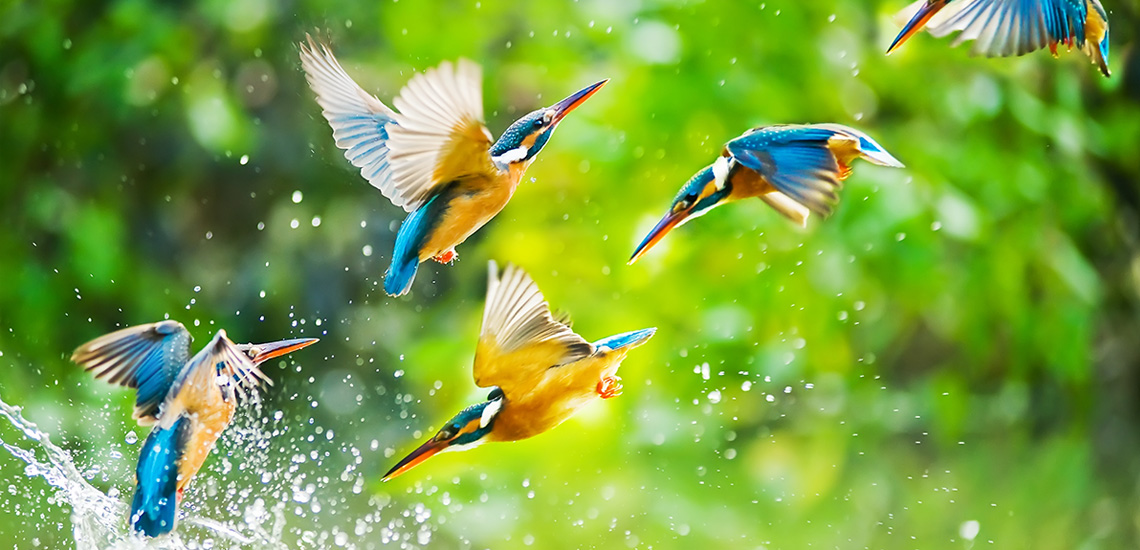

In [8]:
Image(r.content, width=500)

This path within the URL accepts a query string to further specify its behavior.  By using the parameter named `image` we can get the server to return a different image.

In [9]:
r = requests.get(f'http://{host}:{port}/image?name=2')
r.headers['Content-Type']

'image/jpeg'

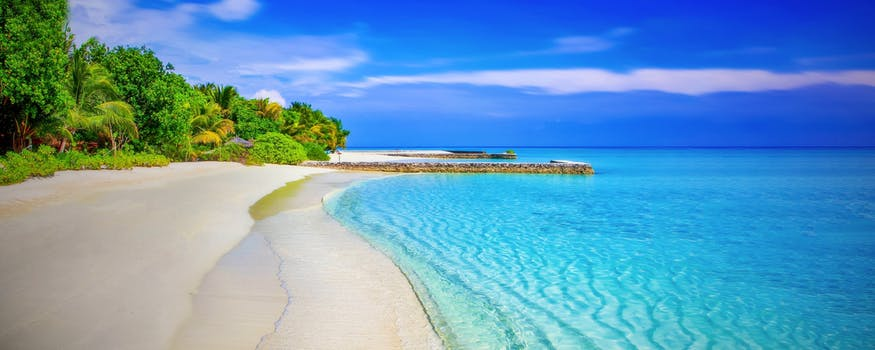

In [10]:
Image(r.content, width=500)

If the image we request in the query parameter is not available, the server will provide an appropriate status code.

In [11]:
r = requests.get(f'http://{host}:{port}/image?name=unknown')
r.headers['Content-Type']

'text/html; charset=utf-8'

In [12]:
r.status_code

404

In [13]:
HTML(r.text)

### Multiple arguments and other HTTP methods

So far, the requests we have made have all been GET requests.  The query portion of a URL allows us to pass in parameter data.  However, if we wish to use large or binary data as part of our request, using a PUT or POST method is more suitable.  A GET request is perfectly fine to pass in several small arguments thought.

In [14]:
r = requests.get(f'http://{host}:{port}/json?this=37&that=abcde&other=3.1415')
r.headers['Content-Type']

'application/json'

In [15]:
r.text

'{"Server":"Test Server #1","other":"3.1415","that":"abcde","this":"37"}\n'

In [16]:
import json
json.loads(r.text)

{'Server': 'Test Server #1', 'other': '3.1415', 'that': 'abcde', 'this': '37'}

In [17]:
data = {'Name': 'Euler', 'Number': 2.718, 'object': object()}
# PUT or POST for large data
r = requests.post(f'http://{host}:{port}/json', data=data)
r.headers['Content-Type']

'application/json'

In [18]:
json.loads(r.text)

{'Name': 'Euler',
 'Number': '2.718',
 'Server': 'Test Server #1',
 'object': '<object object at 0x7f2286291970>'}